In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.path.append("..")

In [5]:
from util import show, plot_images, plot_tensors

In [6]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()

])
train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(
    root=GT_DATA_PATH, transform=TRANSFORM_IMG)

dataset1 = train_data
dataset2 = gt_data

In [7]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / batch_size % batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)

newdataset = gtmatch(dataset1, dataset2, 50)

In [8]:
batch_size=50
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.05

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [9]:
newdataset = SyntheticNoiseDataset(newdataset, 'train')

In [10]:
from models.RIM import RIM
from models.babyunet import BabyUnet

In [11]:
model = RIM()
model2 = BabyUnet()

In [12]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [13]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
random_seed = 42
shuffle_dataset = False

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)


train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)

    


## RIM

In [ ]:
data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_val_loss = 1

for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch

    model.train()

    net_input = noisy_images

    if i == 0:

        st = torch.zeros(net_input.size())

    net_output, st = model(net_input, st)

    loss = loss_function(net_output, noisy_images)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())
    model.eval()

    val_loss = loss_function(net_output, noisy_images)

    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = noisy_images*model(noisy_images, st)[0].detach()
        net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
        denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        clean_comp = clean_images.detach().cpu().numpy()[
            0, 0].astype(np.float64)
        best_psnr = compare_psnr(clean_comp, denoised_arr)
        noisy_input.append(net_input_np)
        best_images.append(denoised_arr)
        clean_image_corr.append(clean_images)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

In [ ]:
plot_images(best_images[::2])

In [ ]:
model_output=[]
Input_PSNR=[]
Model_PSNR=[]
for i, batch in enumerate(validation_loader):

    noisy_images, clean_images = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images*model(noisy_images, st)[0].detach()
    denoised_arr = np.clip(denoised,0,1).cpu().numpy()[0, 0].astype(np.float64)

    net_input_np=noisy_images.cpu().numpy()[0,0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
                         0, 0].astype(np.float64)
    Input_PSNR.append(compare_psnr(clean_comp,net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp,denoised_arr))
    model_output.append([torch.from_numpy(net_input_np),torch.from_numpy(denoised_arr),torch.from_numpy(clean_comp)])

In [ ]:
plot_tensors(model_output[0],["Input","RIM","Ground Truth"])
print("Input PSNR = ",np.round(np.mean(Input_PSNR),2))
print("RIM PSNR = ",np.round(np.mean(Model_PSNR)),2)

## RIM with J-Invariant Mask

In [25]:
from mask_RIM import Masker
masker = Masker(width=4, mode='interpolate')

data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_Jimages=[]
best_val_loss = 1


for i, batch in enumerate(data_loader):
    noisy_images, clean_images = batch

    model.train()

    net_input, mask = masker.mask(noisy_images, i % (masker.n_masks - 1))

    if i == 0:
        st = torch.zeros(net_input.size())

    net_output, st = model(net_input, st)

    loss = loss_function(net_output*mask, noisy_images*mask)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())

    model.eval()
    val_loss = loss_function(net_output*mask, noisy_images*mask)
    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = noisy_images*model(noisy_images, st)[0].detach()
        Jinv=noisy_images*masker.infer_full_image(noisy_images,model, st)[0].detach()
        Jinv=np.clip(Jinv, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
        denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        clean_comp = clean_images.detach().cpu().numpy()[
            0, 0].astype(np.float64)
        
        best_psnr = compare_psnr(clean_comp, Jinv)
        
        noisy_input.append(net_input_np)
        best_images.append(denoised_arr)
        best_Jimages.append(Jinv)
        clean_image_corr.append(clean_images)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

Loss ( 0 ): 	 0.0007


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  27.02
Loss ( 1 ): 	 0.0014
Loss ( 2 ): 	 0.0007
	Model PSNR:  32.36
Loss ( 3 ): 	 0.0006
	Model PSNR:  34.72
Loss ( 4 ): 	 0.0008
Loss ( 5 ): 	 0.0006
	Model PSNR:  29.69
Loss ( 6 ): 	 0.0007
Loss ( 7 ): 	 0.0008
Loss ( 8 ): 	 0.0005
	Model PSNR:  34.54
Loss ( 9 ): 	 0.0005
Loss ( 10 ): 	 0.0011
Loss ( 11 ): 	 0.0005
	Model PSNR:  27.37
Loss ( 12 ): 	 0.0004
	Model PSNR:  32.67
Loss ( 13 ): 	 0.0004
	Model PSNR:  29.67
Loss ( 14 ): 	 0.0006
Loss ( 15 ): 	 0.001


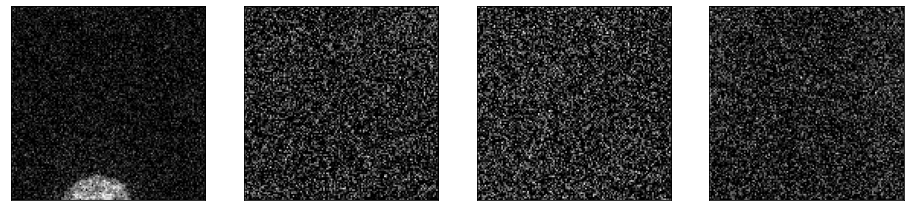

In [26]:
plot_images(best_images[::2])

In [38]:
model_output=[]
Input_PSNR=[]
Model_PSNR=[]
JInv_PSNR=[]
Model_loss=[]
clipped_model_loss=[]
for i, batch in enumerate(validation_loader):

    noisy_images, clean_images = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images*model(noisy_images, st)[0].detach()
    denoised_arr = np.clip(denoised,0,1).cpu().numpy()[0, 0].astype(np.float64)
    Jinv=noisy_images*masker.infer_full_image(noisy_images,model, st)[0].detach()
    Jinv=np.clip(Jinv, 0, 1).cpu().numpy()[
    0, 0].astype(np.float64)

    net_input_np=noisy_images.cpu().numpy()[0,0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
                         0, 0].astype(np.float64)

    model_output.append([torch.from_numpy(net_input_np),torch.from_numpy(denoised_arr),torch.from_numpy(Jinv),torch.from_numpy(clean_comp)])
    Input_PSNR.append(compare_psnr(clean_comp,net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp,denoised_arr))
    JInv_PSNR.append(compare_psnr(clean_comp,Jinv))
    Model_loss.append(loss_function(denoised,noisy_images))
    clipped_model_loss.append(loss_function(torch.from_numpy(denoised_arr),noisy_images))
    


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([50, 1, 128, 128])) that is different to the input size (torch.Size([128, 128])). This will likel

Input PSNR =  26.01
Simple RIM PSNR =  27.53
J-Invariant RIM PSNR =  27.53
Simple RIM Loss =  0.0082
Clipped Simple RIM Loss =  0.0087


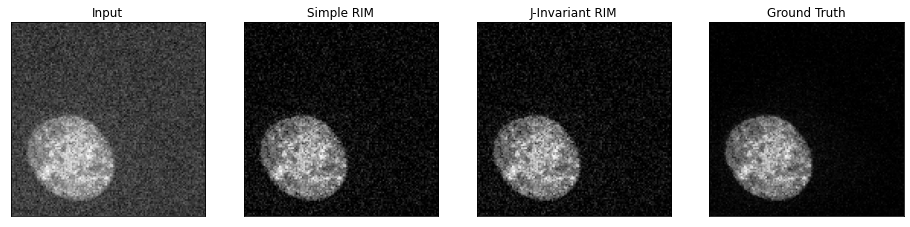

In [45]:
plot_tensors(model_output[1], ["Input", "Simple RIM",
                               "J-Invariant RIM", "Ground Truth"])
print("Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 2))
print("J-Invariant RIM PSNR = ", np.round(np.mean(JInv_PSNR), 2))
print("")
print("Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))

## BABY UNET COMPARISON

In [ ]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

data_loader = train_loader

#noisy, clean = noisy_data_train[0];
#net_input, mask = masker.mask(noisy.unsqueeze(0), 0);

losses = []
val_losses = []
best_images = []
best_val_loss = 1



for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch
    
    model2.train()
 
    net_input, mask = masker.mask(noisy_images, i)
    #net_input = noisy_images
    
    net_output = model2(net_input)

        
    loss = loss_function(net_output*mask, noisy_images*mask)
    #loss = loss_function(net_output, noisy_images)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()

    losses.append(loss.item())
    model2.eval()
    

    val_loss = loss_function(net_output*mask, noisy_images*mask)
    #val_loss = net_output

    val_losses.append(val_loss.item())



    print("Loss (", i, "): \t", round(loss.item(), 4))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = np.clip(model2(noisy_images).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        clean=np.clip(clean_images.detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        best_psnr = compare_psnr(denoised, clean)
        best_images.append(denoised)
        print("\tModel PSNR: ", np.round(best_psnr, 2))


In [ ]:
plot_images(best_images)

In [ ]:
i, test_batch = next(enumerate(validation_loader))
noisy, clean = test_batch

from mask import Masker

simple_output = model2(noisy)
invariant_output = masker.infer_full_image(noisy, model2)

In [ ]:
idx = 3
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [ ]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output[0]).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))

In [ ]:
plot_tensors(invariant_output[idx]-noisy[idx])

In [ ]:
plot_tensors(noisy)